In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import math

import ruptures as rpt

In [2]:
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.signal import find_peaks
import scipy.fft
from itertools import product

In [3]:
import yfinance as yf
## FRED 정보 수집
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

In [4]:
# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
# px를 쉽고 빠르게 붙여주는 모듈 cufflinksget_rsi
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)

In [5]:
%run ../library/QUANT_FUNCTIONS.ipynb
Q = QUANT()
D = DATA()

In [6]:
df = D.get_merged_df('^IXIC', '^GSPC')
df = df.fillna(method = 'pad')

[*********************100%***********************]  2 of 2 completed


In [7]:
dataset = df[['^GSPC']].copy()

## 기준지표 생성
## MA20
dataset['M_st'] = dataset['^GSPC'].rolling(20).mean()
## MA120
dataset['M_lt'] = dataset['^GSPC'].rolling(120).mean()
dataset['S_lt'] = dataset['^GSPC'].rolling(120).std()
## MA120 +- 3*STD120
dataset['UB'] = dataset['M_lt'] + dataset['S_lt']*3
dataset['DB'] = dataset['M_lt'] - dataset['S_lt']*3

dataset = dataset[['^GSPC', 'M_st', 'UB', 'DB']].dropna()

## 모맨텀 발생
dataset['momentum'] = dataset['^GSPC'] > dataset['M_st']

## 상하방 밴드 이탈
dataset['overbought'] = dataset['^GSPC'] >= dataset['UB']
dataset['oversold'] = dataset['^GSPC'] <= dataset['DB']

In [ ]:
dataset['signal'] = dataset['momentum'].copy()

In [ ]:
dataset['signal'][dataset['overbought'] == True] = False
dataset['signal'][dataset['oversold'] == True] = True

In [43]:
## 신호 변동발생 확인
dataset['prev'] = dataset['signal'].shift(1)
dataset['change'] = False
dataset['change'][dataset['signal'] != dataset['prev']] = True

## 포지션 보유 지정
dataset['position'] = False
dataset['position'][(dataset['signal'] == True)&(dataset['change'] == False)] = True
dataset['position'][(dataset['signal'] == False)&(dataset['change'] == True)] = True

In [44]:
new_df = dataset.copy()
new_df['rets'] = new_df['^GSPC'].pct_change()
new_df = new_df.dropna(subset = ['rets'])

In [45]:
new_df['rets_cum'] = (new_df['rets'] + 1).cumprod()
new_df['rets_cum_str'] = (new_df['rets'][new_df['position'] == True] + 1).cumprod()
new_df['rets_cum_str'] = new_df['rets_cum_str'].fillna(method='pad').fillna(1)

<AxesSubplot:xlabel='Date'>

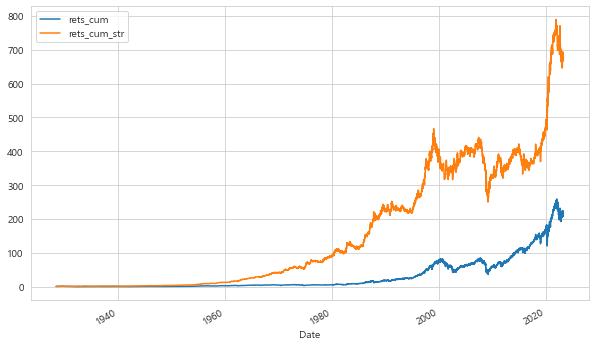

In [46]:
new_df[['rets_cum', 'rets_cum_str']].plot()